# Simple Navigation Simulation

## Populate Sparse Information on Grid

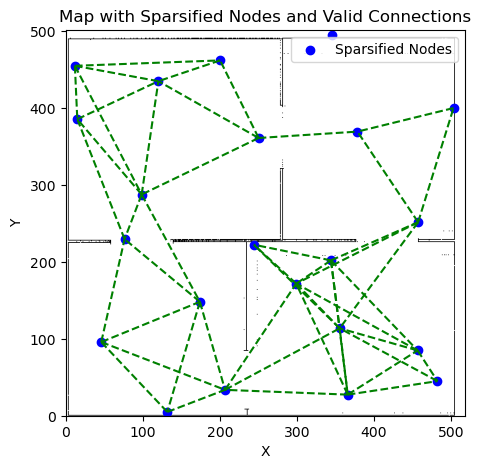

Sparse Node 0: Position: (344.26, 201.74), Connected Nodes (Green): [3, 4, 5, 17, 19, 20], Connected Node (Orange): []
Sparse Node 1: Position: (250.29, 360.7), Connected Nodes (Green): [6, 10, 14, 21], Connected Node (Orange): []
Sparse Node 2: Position: (11.67, 454.44), Connected Nodes (Green): [6, 8, 10, 14], Connected Node (Orange): []
Sparse Node 3: Position: (457.45, 251.35), Connected Nodes (Green): [7, 17, 19, 21, 0], Connected Node (Orange): []
Sparse Node 4: Position: (366.01, 27.4), Connected Nodes (Green): [5, 15, 16, 17, 19, 0], Connected Node (Orange): []
Sparse Node 5: Position: (456.81, 84.75), Connected Nodes (Green): [16, 17, 19, 0, 4], Connected Node (Orange): []
Sparse Node 6: Position: (98.38, 287.29), Connected Nodes (Green): [8, 12, 14, 18, 1, 2], Connected Node (Orange): []
Sparse Node 7: Position: (503.38, 399.58), Connected Nodes (Green): [21, 3], Connected Node (Orange): []
Sparse Node 8: Position: (14.79, 385.12), Connected Nodes (Green): [14, 18, 2, 6], Con

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_euclidean_distance(node1, node2):
    return np.linalg.norm(node1 - node2)

def twc_similarity(node1, node2, nodes, threshold):
    '''
    Compute two-way consistency (TWC) similarity between two nodes
    TWC ensures that both nodes can be reached with similar effort from their neighbors
    and all their neighbors can be reached from both nodes with similar effort
    '''

    c_out = max(calculate_euclidean_distance(node1, w) - calculate_euclidean_distance(node2, w) for w in nodes)
    c_in = max(calculate_euclidean_distance(s0, node1) - calculate_euclidean_distance(s0, node2) for s0 in nodes)

    return c_out <= threshold and c_in <= threshold


def sparsify_graph(nodes, threshold):
    '''
    For now, this merges nodes that are close to each other 
    based off TWC simplicity
    '''
    
    merged_nodes = []

    for node in nodes:
        #check if the node has already been merged
        already_merged = False
        for merged_node in merged_nodes:
            if calculate_euclidean_distance(node, merged_node) <= threshold:
                already_merged = True
                break
        
        if not already_merged:
            neighbors = [n for n in nodes if not np.array_equal(n, node) and calculate_euclidean_distance(node, n) <= threshold]

            similar_nodes = [n for n in neighbors if twc_similarity(node, n, nodes, threshold)]

            # perform merging if node is similar enough
            if similar_nodes:
                merged_node = np.mean(np.array(similar_nodes + [node]), axis=0)  # Centroid as the representative node
                merged_nodes.append(merged_node)
            else:
                merged_nodes.append(node)

    return merged_nodes

def is_line_intersecting_obstacle(node1, node2, map_data):
    ''' 
    Check if line between two Sparse Nodes is colliding w a wall, using map pixel value.
    If so, then we want to reject this line, since robot will crash into the wall in simulation.
    '''
    
    x1, y1 = node1
    x2, y2 = node2
    
    x1 = x1 * image_width
    x2 = x2 * image_width
    y1 = y1 * image_height
    y2 = y2 * image_height
    
    num_samples = int(max(abs(x2 - x1), abs(y2 - y1))) + 1
    
    x_coords = np.linspace(x1 , x2 , num_samples)
    y_coords = np.linspace(y1, y2, num_samples)
    
    for x, y in zip(x_coords, y_coords):
        x_pixel = int(round(x))
        y_pixel = int(round(y))

        if 0 <= y_pixel < map_data.shape[0] and 0 <= x_pixel < map_data.shape[1]:
            if map_data[y_pixel, x_pixel] != 0:
                return True
    
    # If no intersections found
    return False

def draw_lines(sparse_nodes, map_data, threshold, image_width, image_height):
    '''
    Draw lines connecting sparse nodes within threshold distance,
    as well as do its best to connect isolated nodes.
    Cuts lines that are clipping through walls as cleanup.
    Also store information about each node as a dictionary.
    '''
    
    # Store connected nodes information for each sparse node
    sparse_info = {} 
    connected_pairs = set() 

    # Loop though nodes within threshold distance
    for i in range(len(sparse_nodes)):
        connected_nodes = []
        for j in range(len(sparse_nodes)):
            if i != j:
                dist = calculate_euclidean_distance(sparse_nodes[i], sparse_nodes[j])
                if dist <= threshold * min(image_width, image_height) / max(image_width, image_height):
                    # check if the pair of nodes is not already connected
                    if (i, j) not in connected_pairs and (j, i) not in connected_pairs:
                        # check if the line intersects with any obstacle and add if no interference 
                        if not is_line_intersecting_obstacle(sparse_nodes[i], sparse_nodes[j], map_data):
                            plt.plot([sparse_nodes[i][0] * image_width, sparse_nodes[j][0] * image_width], [sparse_nodes[i][1] * image_height, sparse_nodes[j][1] * image_height], color='green', linestyle='--')
                            connected_nodes.append(j)
                            # add the connected pair to the set
                            connected_pairs.add((i, j))
                        # else:
                        #     # line intersects with obstacle
                        #     plt.plot([sparse_nodes[i][0] * image_width, sparse_nodes[j][0] * image_width], [sparse_nodes[i][1] * image_height, sparse_nodes[j][1] * image_height], color='red', linestyle='--')
        
        # add connected node info to our collection
        sparse_info[i] = {'position': sparse_nodes[i], 'connected_nodes_green': connected_nodes}

    # draw lines from each unconnected sparse node to its nearest sparse node
    for i in range(len(sparse_nodes)):
        if not sparse_info[i]['connected_nodes_green']:
            min_dist = float('inf')
            nearest_idx = None
            for j in range(len(sparse_nodes)):
                if i != j:
                    dist = calculate_euclidean_distance(sparse_nodes[i], sparse_nodes[j])
                    if dist < min_dist:
                        min_dist = dist
                        nearest_idx = j
            if nearest_idx is not None:
                # check if the pair of nodes is not already connected
                if (i, nearest_idx) not in connected_pairs and (nearest_idx, i) not in connected_pairs:
                    # check if the line intersects with any obstacle and add if no interference
                    if not is_line_intersecting_obstacle(sparse_nodes[i], sparse_nodes[nearest_idx], map_data):
                        plt.plot([sparse_nodes[i][0] * image_width, sparse_nodes[nearest_idx][0] * image_width], [sparse_nodes[i][1] * image_height, sparse_nodes[nearest_idx][1] * image_height], color='orange', linestyle='--')
                        sparse_info[i]['connected_node_orange'] = nearest_idx
 
                        connected_pairs.add((i, nearest_idx))
                    # else:
                    #     # line intersects with obstacle
                    #     plt.plot([sparse_nodes[i][0] * image_width, sparse_nodes[nearest_idx][0] * image_width], [sparse_nodes[i][1] * image_height, sparse_nodes[nearest_idx][1] * image_height], color='red', linestyle='--')

    # So we can have two way connection in our sparse_info collection     
    for idx, info in sparse_info.items():
        for connected_node_idx in info.get('connected_nodes_green', []):
            if idx not in sparse_info[connected_node_idx].get('connected_nodes_green', []):
                sparse_info[connected_node_idx].get('connected_nodes_green', []).append(idx)
            
        for connected_node_idx in info.get('connected_nodes_orange', []): 
            if idx not in sparse_info[connected_node_idx].get('connected_nodes_orange', []):
                sparse_info[connected_node_idx].get('connected_nodes_orange', []).append(idx)


    return sparse_info


# NOTE: starts here
nodes = np.random.rand(50, 2) 
similarity_threshold = 0.15
distance_threshold = 0.4

sparse_nodes = sparsify_graph(nodes, similarity_threshold)
sparse_nodes = np.array(sparse_nodes)

map_data = np.load('map_data.npy') # this contains information of the walls
image_height = map_data.shape[0]
image_width = map_data.shape[1]

# plot visualization graph
plt.figure(figsize=(image_width / 100, image_height / 100))  # Convert pixel units to inches
plt.xlim(0, image_width)
plt.ylim(0, image_height)

# plot walls
plt.imshow(map_data, cmap='binary', origin='lower')

# plot original nodes
# plt.scatter(nodes[:, 0] * image_width, nodes[:, 1] * image_height, color='blue', label='Original Nodes')

# plot sparsified nodes
plt.scatter(sparse_nodes[:, 0] * image_width, sparse_nodes[:, 1] * image_height, color='blue', label='Sparsified Nodes')

sparse_info = draw_lines(sparse_nodes, map_data, distance_threshold, image_width, image_height)

plt.title('Map with Sparsified Nodes and Valid Connections')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.show()

# DEBUG: just to see information
for idx, info in sparse_info.items():
    print(f"Sparse Node {idx}: Position: ({round(info['position'][0] * image_width, 2)}, {round(info['position'][1] * image_height, 2)}), Connected Nodes (Green): {info.get('connected_nodes_green', [])}, Connected Node (Orange): {info.get('connected_node_orange', [])}")


## Find shortest distance from one node to another

For now this uses Breadth First Search

In [2]:
from collections import deque

def find_shortest_path(sparse_info, start_node_idx, end_node_idx):
    '''
    perform BFS-Dijkstra (for now) and find the nodes that one must travel to get to destination node
    '''
    
    
    distances = {idx: float('inf') for idx in sparse_info}
    distances[start_node_idx] = 0

    queue = deque([(start_node_idx, [])])

    while queue:
        current_node_idx, path = queue.popleft()
        if current_node_idx == end_node_idx:
            return path + [current_node_idx]  
        for connected_node_idx in sparse_info[current_node_idx].get('connected_nodes_green', []) + sparse_info[current_node_idx].get('connected_nodes_orange', []):
            # find distance
            distance_to_connected_node = distances[current_node_idx] + calculate_euclidean_distance(sparse_info[current_node_idx]['position'], sparse_info[connected_node_idx]['position'])
            # update lowest distance if needed
            if distance_to_connected_node < distances[connected_node_idx]:
                distances[connected_node_idx] = distance_to_connected_node
                queue.append((connected_node_idx, path + [current_node_idx]))
    # return None if no possible path found
    # TODO: this should actually just return sth to be caught ltr one
    return None

# Example usage
start_node_idx = 0 
end_node_idx = 4  

shortest_path = find_shortest_path(sparse_info, start_node_idx, end_node_idx) # this can return None

if shortest_path:
    print(f"Shortest path from node {start_node_idx} to node {end_node_idx}: {shortest_path}")
else:
    print(f"No path found from node {start_node_idx} to node {end_node_idx}")


Shortest path from node 0 to node 4: [0, 4]


### Find nearest node to a specific point
This is for the robot initialisation where the robot needs to go to a point and then start taking stuff from there.

In [3]:
def find_nearest_node(point, sparse_nodes):
    min_distance = float('inf')
    nearest_node = None
    for idx, node in enumerate(sparse_nodes):
        distance = calculate_euclidean_distance(point, node)
        if distance < min_distance:
            min_distance = distance
            nearest_node = idx
    return nearest_node

# Example usage
point = np.array([6.83/image_width, 18.3/image_height])
nearest_node_idx = find_nearest_node(point, sparse_nodes)
nearest_node_position = sparse_nodes[nearest_node_idx]

print(f"The nearest node to point {point} is at index {nearest_node_idx} with position {nearest_node_position}")


The nearest node to point [0.01318533 0.03652695] is at index 11 with position [0.08860581 0.19097568]


### Movement from One Node to Another

In [7]:
import math

def calculate_angle_and_distance(node1, node2, current_direction):
    # Extract coordinates of node1 and node2
    x1, y1 = node1
    x2, y2 = node2
    
    # Calculate the angle to rotate from the current direction to face node2
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1)) - current_direction
    
    # Normalize angle to be between -180 and 180 degrees
    angle = angle % 360
    
    # Calculate the distance between node1 and node2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Update the current direction of the robot to face node2
    current_direction = (current_direction + angle) % 360
    
    return angle, distance, current_direction

# Example usage:
node1 = (9.3043869669492, 18.38147617180835)  # Assuming the robot starts at the origin
node2 = (6.423578720044662, 14.033849041523352)  # Coordinates of the target node
current_direction = 1.870833066243852  # Assuming the robot is initially facing in the +ve x direction

angle, distance, current_direction = calculate_angle_and_distance(node1, node2, current_direction)
print("Angle:", angle)
print("Distance:", distance)
print("Updated current direction:", current_direction)


Angle: 234.60006624541836
Distance: 5.215449915340323
Updated current direction: 236.4708993116622
